In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pyrosm
import contextily as cx 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
ox.__version__

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


'1.1.2'

In [2]:
filename = "lejeboliger_2019_t_april23.csv"

In [3]:
df = pd.read_csv(filename, sep= ";", decimal = ".", dtype={'antal værelser': object, 'lon': float, 'lat': float})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540 entries, 0 to 2539
Data columns (total 96 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   leje                                        2540 non-null   int64  
 1   forudbetalt_leje                            2360 non-null   float64
 2   tilgængelig_fra                             2540 non-null   object 
 3   tilgængelig_til                             5 non-null      object 
 4   max_lejeperiode_måned                       36 non-null     float64
 5   Sagsnr                                      2540 non-null   object 
 6   udbetaling                                  2540 non-null   int64  
 7   realtor_name                                2540 non-null   object 
 8   realtor_zip_code                            2540 non-null   int64  
 9   realtor_road                                2540 non-null   object 
 10  realtor_hous

In [4]:
# Hver leje har et unikt sagsnummer 
duplicates = df['Sagsnr'].duplicated()
duplicates_df = df[duplicates]
duplicates_df

,leje,forudbetalt_leje,tilgængelig_fra,tilgængelig_til,max_lejeperiode_måned,Sagsnr,udbetaling,realtor_name,realtor_zip_code,realtor_road,...,highlighted_until,cadastral_district_id,land_parcel_id,distinction,weighted_area,realtor_deleted,per_area_price,secondary_address_type,custom_areas,utilities_connection_fee_included_in_price
82,10400,10400.0,2022-09-01,NaN,NaN,11803272,31200,EDC Projekt Poul Erik Bech,1069,Bremerholm,...,NaN,NaN,NaN,rental,NaN,False,678.0,NaN,"{Amager,Amager Øst,Sjælland,København By}",NaN
135,7500,7500.0,2022-08-10,NaN,NaN,1770009188177009,22500,home Sydhavnen & Projektsalg,2450,Teglholmsgade,...,NaN,NaN,NaN,rental,NaN,False,726.0,NaN,"{Sjælland,København By}",NaN
229,7500,7500.0,2022-09-27,NaN,NaN,1770009358177009,22500,home Sydhavnen & Projektsalg,2450,Teglholmsgade,...,NaN,NaN,NaN,rental,NaN,False,726.0,NaN,"{Sjælland,København By}",NaN
234,7200,7200.0,2022-09-29,NaN,NaN,1770009712177009,21600,home Sydhavnen & Projektsalg,2450,Teglholmsgade,...,NaN,NaN,NaN,rental,NaN,False,527.0,NaN,"{Sjælland,København By}",NaN
236,14300,14300.0,2022-10-15,NaN,NaN,11803410,42900,EDC Projekt Poul Erik Bech,1069,Bremerholm,...,NaN,NaN,NaN,rental,NaN,False,631.0,NaN,"{Amager,Christianshavn,Sjælland,København By}",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2527,16950,16950.0,2023-04-15,NaN,NaN,11804021,50850,EDC Projekt Poul Erik Bech,1069,Bremerholm,...,NaN,NaN,NaN,rental,NaN,False,598.0,NaN,"{Amager,Christianshavn,Sjælland,København By}",NaN
2530,16650,16650.0,2022-02-01,NaN,NaN,10-X00018203426001,32400,LokalBolig Amager ApS,2300,Holmbladsgade,...,NaN,NaN,NaN,rental,141,False,230.0,NaN,"{Amager,Amager Vest,Ørestad,Sjælland,København...",NaN
2532,11950,11950.0,2022-06-30,NaN,NaN,1770008716177009,35850,home Sydhavnen & Projektsalg,2450,Teglholmsgade,...,NaN,NaN,NaN,rental,NaN,False,629.0,NaN,"{Amager,Amager Vest,Ørestad,Sjælland,København...",NaN
2534,15800,15800.0,2023-04-01,NaN,NaN,11803827,47400,EDC Projekt Poul Erik Bech,1069,Bremerholm,...,NaN,NaN,NaN,rental,NaN,False,521.0,NaN,"{Østerbro,Sjælland,København By}",NaN


In [5]:
# columns from boligzonen: ["rooms", "area", "rent", "street", "zip_code", "latitude", "longitude"]
columns = ["Sagsnr", "tilgængelig_fra", "antal værelser", "boligareal", "leje", "road_name", "zip_code", "lat", "lon"]
df = df[columns]
df2 = df.rename(columns={"tilgængelig_fra": "available_from", "antal værelser": "rooms", "boligareal": "area", "leje": "rent", "road_name": "street", "lon": "longitude", "lat" : "latitude"})

,Sagsnr,antal værelser,boligareal,leje,lon,lat
0,1770011017177hom,4,128.0,21500,12.553821,55.649226
1,1770011439177hom,2,81.0,16700,12.567339,55.658052
2,1770010150177009,1,29.0,7500,12.510115,55.659268
3,11803546,5,140.0,18600,12.542862,55.651663
4,199500004911995004,3,93.0,15000,12.577208,55.634762
...,...,...,...,...,...,...
2535,11803907,4,112.0,18600,12.553745,55.648378
2536,1770010476177009,3,66.0,12600,12.582683,55.639684
2537,1770010462177009,4,103.0,16200,12.568378,55.619356
2538,1770011168177hom,4,102.0,17100,12.553316,55.649410


In [7]:
gdf = gpd.GeoDataFrame(
    df2, geometry=gpd.points_from_xy(df.lon, df.lat))

In [8]:
gdf[:10]

,Sagsnr,antal værelser,boligareal,leje,lon,lat,geometry
0,1770011017177hom,4,128.0,21500,12.553821,55.649226,POINT (12.55382 55.64923)
1,1770011439177hom,2,81.0,16700,12.567339,55.658052,POINT (12.56734 55.65805)
2,1770010150177009,1,29.0,7500,12.510115,55.659268,POINT (12.51012 55.65927)
3,11803546,5,140.0,18600,12.542862,55.651663,POINT (12.54286 55.65166)
4,199500004911995004,3,93.0,15000,12.577208,55.634762,POINT (12.57721 55.63476)
...,...,...,...,...,...,...,...
2535,11803907,4,112.0,18600,12.553745,55.648378,POINT (12.55375 55.64838)
2536,1770010476177009,3,66.0,12600,12.582683,55.639684,POINT (12.58268 55.63968)
2537,1770010462177009,4,103.0,16200,12.568378,55.619356,POINT (12.56838 55.61936)
2538,1770011168177hom,4,102.0,17100,12.553316,55.649410,POINT (12.55332 55.64941)


NameError: name 'mpl' is not defined

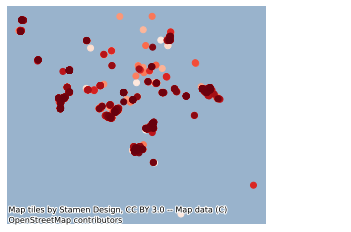

In [9]:
# Plotting 

import seaborn as sns

sns.set(rc={'figure.figsize':(26,12)})
sns.lmplot('area', 'rent', data=df2, hue='rooms', fit_reg=False, height=12, aspect=1)

plt.show()